# AXI Traffic Generator

In [1]:
import logging
import re
import subprocess
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from fpga_mngr_interface.FpgaManagerInterface import FpgaManagerInterface
from zynqmp_pl_ps import AxiProxy, Udmabuf, UioDev

## Programming the FPGA

We check if the FPGA is programmed, and if that is not the case, we program it with the appropriate bitstream and device tree overlay.

In [2]:
# logging.basicConfig(level=logging.DEBUG)

fmi = FpgaManagerInterface()
is_programmed = fmi.is_programmed()

try:
    UioDev.get_uio_dev_file("AxiTrafficGen", "hp")
    atg_found = True
except RuntimeError:
    atg_found = False

print(f"is programmed: {is_programmed}, AXI TG found: {atg_found}")

if not is_programmed or not atg_found:
    print("Re-programming the FPGA")
    fmi.remove()
    fmi.program_bitstream(
        "/lib/firmware/xilinx/axi_traffic_gen/axi_traffic_gen.bit.bin",
        "/lib/firmware/xilinx/axi_traffic_gen/axi_traffic_gen.dtbo",
    )

is programmed: True, AXI TG found: False
Re-programming the FPGA


## Infrastructure around `app-axi-traffic-gen`

In [3]:
@dataclass(frozen=True)
class Config:
    use_osync: bool
    axi_cache: int
    axi_prot: int
    axi_user: int


@dataclass(frozen=True)
class Stats:
    rd_cyc: int
    wr_cyc: int
    count_beats: int

In [4]:
RE_STATS = re.compile(
    r"stats: rd cyc = (?P<rd_cyc>\d+), wr cyc = (?P<wr_cyc>\d+), rd_ok = (?P<count_beats>\d+)"
)


def run_atg(interface: str, size_bursts: int, config: Config) -> Stats:
    args = [
        "app-axi-traffic-gen",
        "--interface",
        interface,
        "--count",
        str(size_bursts),
        "--axi-prot",
        str(config.axi_prot),
        "--axi-cache",
        str(config.axi_cache),
        "--axi-user",
        str(config.axi_user),
    ]

    if config.use_osync:
        args.append("--use-osync")

    resp = subprocess.check_output(args)

    for line in resp.decode("ascii").split("\n"):
        if m := RE_STATS.match(line):
            m_dict = {k: int(v) for k, v in m.groupdict().items()}
            return Stats(**m_dict)

    raise RuntimeError("Unable to find the 'stats:' line")

## Measurement configuration

In [5]:
udmabuf = Udmabuf.Udmabuf("axi:udmabuf@0x0")
BUFFER_SIZE = udmabuf.buf_size
print(f"Buffer size: {BUFFER_SIZE}")
del udmabuf

Buffer size: 33554432


In [6]:
NR_MEAS_PER_SIZE = 5

BYTES_PER_BEAT = 128 // 8
BEATS_PER_BURST = 4

sizes_burst = [
    2 ** i
    for i in range(int(np.log2(BUFFER_SIZE / BEATS_PER_BURST / BYTES_PER_BEAT)) + 1)
]

CONFIGS = {
    "hp": Config(use_osync=True, axi_cache=0, axi_prot=0, axi_user=0),
    "hpc": Config(use_osync=False, axi_cache=15, axi_prot=2, axi_user=1),
    "acp": Config(use_osync=False, axi_cache=15, axi_prot=2, axi_user=1),
}

## Measurement

In [7]:
meas = dict()

for interface, config in CONFIGS.items():

    sizes_bytes = []
    durs_rd = []
    durs_wr = []

    for size in sizes_burst:
        size_bytes = size * BEATS_PER_BURST * BYTES_PER_BEAT
        sizes_bytes.append(size_bytes)

        for _ in range(NR_MEAS_PER_SIZE):
            stats = run_atg(interface, size, config)

            print(f"{size_bytes:8}: {stats}")
            assert size_bytes == stats.count_beats * BYTES_PER_BEAT

            durs_rd.append(stats.rd_cyc)
            durs_wr.append(stats.wr_cyc)

    meas[interface] = dict()
    meas[interface]["size"] = sizes_bytes
    meas[interface]["rd"] = durs_rd
    meas[interface]["wr"] = durs_wr

      64: Stats(rd_cyc=69, wr_cyc=36, count_beats=4)
      64: Stats(rd_cyc=69, wr_cyc=36, count_beats=4)
      64: Stats(rd_cyc=81, wr_cyc=36, count_beats=4)
      64: Stats(rd_cyc=109, wr_cyc=36, count_beats=4)
      64: Stats(rd_cyc=72, wr_cyc=36, count_beats=4)
     128: Stats(rd_cyc=193, wr_cyc=40, count_beats=8)
     128: Stats(rd_cyc=92, wr_cyc=39, count_beats=8)
     128: Stats(rd_cyc=73, wr_cyc=40, count_beats=8)
     128: Stats(rd_cyc=74, wr_cyc=40, count_beats=8)
     128: Stats(rd_cyc=83, wr_cyc=39, count_beats=8)
     256: Stats(rd_cyc=81, wr_cyc=48, count_beats=16)
     256: Stats(rd_cyc=81, wr_cyc=47, count_beats=16)
     256: Stats(rd_cyc=192, wr_cyc=48, count_beats=16)
     256: Stats(rd_cyc=104, wr_cyc=48, count_beats=16)
     256: Stats(rd_cyc=81, wr_cyc=48, count_beats=16)
     512: Stats(rd_cyc=150, wr_cyc=77, count_beats=32)
     512: Stats(rd_cyc=238, wr_cyc=79, count_beats=32)
     512: Stats(rd_cyc=169, wr_cyc=79, count_beats=32)
     512: Stats(rd_cyc=142, wr_

   16384: Stats(rd_cyc=9467, wr_cyc=5967, count_beats=1024)
   16384: Stats(rd_cyc=9646, wr_cyc=5929, count_beats=1024)
   16384: Stats(rd_cyc=11206, wr_cyc=5999, count_beats=1024)
   32768: Stats(rd_cyc=18073, wr_cyc=11844, count_beats=2048)
   32768: Stats(rd_cyc=20064, wr_cyc=12103, count_beats=2048)
   32768: Stats(rd_cyc=19939, wr_cyc=11814, count_beats=2048)
   32768: Stats(rd_cyc=18409, wr_cyc=11897, count_beats=2048)
   32768: Stats(rd_cyc=19408, wr_cyc=11896, count_beats=2048)
   65536: Stats(rd_cyc=36300, wr_cyc=24191, count_beats=4096)
   65536: Stats(rd_cyc=37014, wr_cyc=24327, count_beats=4096)
   65536: Stats(rd_cyc=49003, wr_cyc=23327, count_beats=4096)
   65536: Stats(rd_cyc=37574, wr_cyc=24132, count_beats=4096)
   65536: Stats(rd_cyc=37578, wr_cyc=24257, count_beats=4096)
  131072: Stats(rd_cyc=71885, wr_cyc=48378, count_beats=8192)
  131072: Stats(rd_cyc=78059, wr_cyc=48493, count_beats=8192)
  131072: Stats(rd_cyc=102431, wr_cyc=48168, count_beats=8192)
  131072: St

 2097152: Stats(rd_cyc=2478409, wr_cyc=662806, count_beats=131072)
 4194304: Stats(rd_cyc=5234916, wr_cyc=1399698, count_beats=262144)
 4194304: Stats(rd_cyc=5229056, wr_cyc=1400563, count_beats=262144)
 4194304: Stats(rd_cyc=5235055, wr_cyc=1397027, count_beats=262144)
 4194304: Stats(rd_cyc=5224862, wr_cyc=1398878, count_beats=262144)
 4194304: Stats(rd_cyc=5234497, wr_cyc=1401526, count_beats=262144)
 8388608: Stats(rd_cyc=10479197, wr_cyc=2809669, count_beats=524288)
 8388608: Stats(rd_cyc=10476542, wr_cyc=2810154, count_beats=524288)
 8388608: Stats(rd_cyc=10483859, wr_cyc=2809729, count_beats=524288)
 8388608: Stats(rd_cyc=10473298, wr_cyc=2809549, count_beats=524288)
 8388608: Stats(rd_cyc=10481318, wr_cyc=2811272, count_beats=524288)
16777216: Stats(rd_cyc=20974337, wr_cyc=5636347, count_beats=1048576)
16777216: Stats(rd_cyc=20971675, wr_cyc=5636159, count_beats=1048576)
16777216: Stats(rd_cyc=20978335, wr_cyc=5638396, count_beats=1048576)
16777216: Stats(rd_cyc=20978242, wr_cy

## Plotting

In [8]:
@dataclass
class MeasData:
    sizes: np.array
    rd_beat_per_cyc: np.array
    wr_beat_per_cyc: np.array
    sizes_avg: np.array
    rd_beat_per_cyc_avg: np.array
    wr_beat_per_cyc_avg: np.array

In [9]:
def process_meas(data):
    SAMP_PER_SIZE = len(data["rd"]) // len(data["size"])

    sizes_avg = np.array(data["size"])
    sizes = np.repeat(sizes_avg.reshape((-1, 1)), SAMP_PER_SIZE, axis=1).reshape(-1)

    rd = np.array(data["rd"])
    wr = np.array(data["wr"])

    avg = lambda xs: np.mean(xs.reshape((-1, SAMP_PER_SIZE)), axis=1)
    rd_avg = avg(rd)
    wr_avg = avg(wr)

    rd_beat_per_cyc = (sizes / BYTES_PER_BEAT) / rd
    wr_beat_per_cyc = (sizes / BYTES_PER_BEAT) / wr
    rd_beat_per_cyc_avg = (sizes_avg / BYTES_PER_BEAT) / rd_avg
    wr_beat_per_cyc_avg = (sizes_avg / BYTES_PER_BEAT) / wr_avg

    return MeasData(
        sizes,
        rd_beat_per_cyc,
        wr_beat_per_cyc,
        sizes_avg,
        rd_beat_per_cyc_avg,
        wr_beat_per_cyc_avg,
    )

In [10]:
data_apc = process_meas(meas["acp"])
data_hpc = process_meas(meas["hpc"])
data_hp = process_meas(meas["hp"])

Text(0.5, 0, 'transfer size [bytes]')

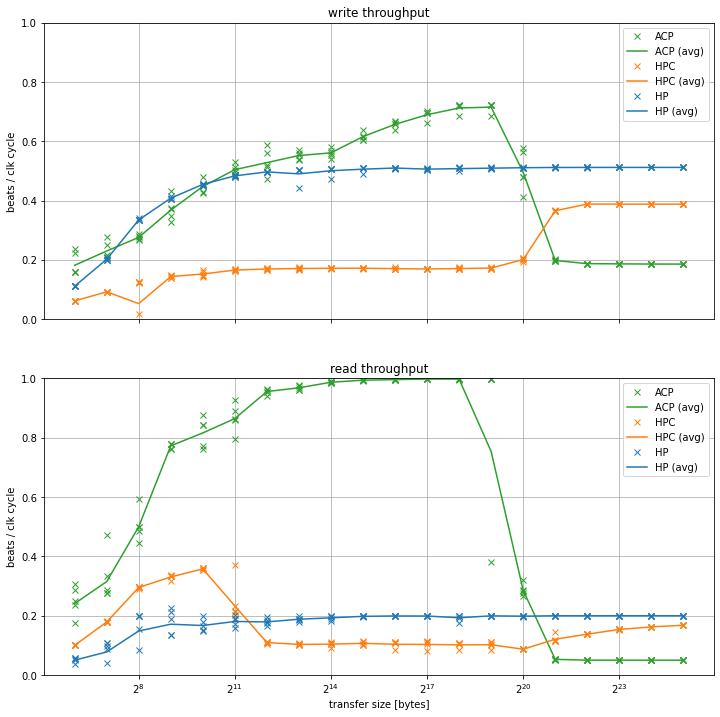

In [11]:
fig = plt.figure(figsize=(12, 12))

ax2, ax1 = fig.subplots(2, 1, sharex=True)

ax1.semilogx(
    data_apc.sizes,
    data_apc.rd_beat_per_cyc,
    "x",
    color="C2",
    label="ACP",
)
ax1.semilogx(
    data_apc.sizes_avg,
    data_apc.rd_beat_per_cyc_avg,
    color="C2",
    label="ACP (avg)",
)
ax1.semilogx(
    data_hpc.sizes,
    data_hpc.rd_beat_per_cyc,
    "x",
    color="C1",
    label="HPC",
)
ax1.semilogx(
    data_hpc.sizes_avg,
    data_hpc.rd_beat_per_cyc_avg,
    color="C1",
    label="HPC (avg)",
)
ax1.semilogx(
    data_hp.sizes,
    data_hp.rd_beat_per_cyc,
    "x",
    color="C0",
    label="HP",
)
ax1.semilogx(
    data_hp.sizes_avg,
    data_hp.rd_beat_per_cyc_avg,
    color="C0",
    label="HP (avg)",
)

ax1.set_ylim((0, 1))
ax1.grid(True)
ax1.legend()
ax1.set_title("read throughput")
ax1.set_ylabel("beats / clk cycle")
ax1.set_xscale("log", base=2)

ax2.semilogx(
    data_apc.sizes,
    data_apc.wr_beat_per_cyc,
    "x",
    color="C2",
    label="ACP",
)
ax2.semilogx(
    data_apc.sizes_avg,
    data_apc.wr_beat_per_cyc_avg,
    color="C2",
    label="ACP (avg)",
)
ax2.semilogx(
    data_hpc.sizes,
    data_hpc.wr_beat_per_cyc,
    "x",
    color="C1",
    label="HPC",
)
ax2.semilogx(
    data_hpc.sizes_avg,
    data_hpc.wr_beat_per_cyc_avg,
    color="C1",
    label="HPC (avg)",
)
ax2.semilogx(
    data_hp.sizes,
    data_hp.wr_beat_per_cyc,
    "x",
    color="C0",
    label="HP",
)
ax2.semilogx(
    data_hp.sizes_avg,
    data_hp.wr_beat_per_cyc_avg,
    color="C0",
    label="HP (avg)",
)

ax2.set_ylim((0, 1))
ax2.grid(True)
ax2.legend()
ax2.set_title("write throughput")
ax2.set_ylabel("beats / clk cycle")
ax2.set_xscale("log", base=2)

ax1.set_xlabel("transfer size [bytes]")

## Conclusion

* all AXI Traffic Generators use the same configuration: 4 burst in flight, each burst has 64 bytes (one cache line); this satisfies the requirements on the ACP port
* those values are too low for the HP and HPC ports (with high latencies of the DDR4 memory) to achieve a high throughput
* because we first write and then read is the read performance on ACP port fanstastic ...
* ... until the transfer size reaches the L2 cache size (1 MB)
